In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np


def compare_experiments(path_A, path_B, name_A="Method A", name_B="Method B"):
    """
    讀取兩個 CSV 評估報表，計算 (A - B) 的差異，並繪製熱力圖與分析數據。
    
    Args:
        path_A (str): 第一個 CSV 檔案路徑 (例如: 有 Warmup)
        path_B (str): 第二個 CSV 檔案路徑 (例如: 無 Warmup)
        name_A (str): 實驗 A 的名稱 (用於圖表標題)
        name_B (str): 實驗 B 的名稱
    """
    
    # 1. 檢查檔案是否存在
    if not os.path.exists(path_A) or not os.path.exists(path_B):
        print("❌ 錯誤：找不到檔案，請檢查路徑。")
        return

    # 2. 讀取資料
    try:
        df_a = pd.read_csv(path_A, index_col=0) # 假設第一欄是 Muscle Name
        df_b = pd.read_csv(path_B, index_col=0)
    except Exception as e:
        print(f"❌ 讀取 CSV 失敗: {e}")
        return

    # 3. 確保行列對齊 (取交集，避免欄位不一致報錯)
    common_index = df_a.index.intersection(df_b.index)
    common_col = df_a.columns.intersection(df_b.columns)
    
    df_a = df_a.loc[common_index, common_col]
    df_b = df_b.loc[common_index, common_col]

    # 4. 計算差異 (Diff = A - B)
    # 正值代表 A 比 B好 (進步)
    # 負值代表 A 比 B差 (退步)
    df_diff = df_a - df_b

    # ==========================================
    # 5. 視覺化 (Heatmap)
    # ==========================================
    plt.figure(figsize=(12, 8))
    
    # 設定顏色：紅色=進步(正), 藍色=退步(負), 白色=持平(0)
    sns.heatmap(df_diff, annot=True, cmap='RdBu_r', center=0, fmt=".4f", 
                linewidths=0.5, linecolor='lightgray')
    
    plt.title(f"Dice Score Difference: ({name_A}) - ({name_B})\nRed = {name_A} is Better | Blue = {name_B} is Better", fontsize=14)
    plt.ylabel("Muscle Region")
    plt.xlabel("MRI Sequence")
    plt.tight_layout()
    plt.show()

    # ==========================================
    # 6. 文字分析報告
    # ==========================================
    print("="*50)
    print(f"📊 分析報告: {name_A} vs {name_B}")
    print("="*50)

    # 總體平均提升
    if 'AVERAGE' in df_diff.index:
        avg_imp = df_diff.loc['AVERAGE'].mean()
        print(f"📈 總體平均提升 (Total Average Gain): {avg_imp:+.4f}")
        print("\n各序列提升 (Per Sequence Gain):")
        print(df_diff.loc['AVERAGE'])
        
        # 移除 AVERAGE 列以便分析個別肌肉
        df_muscles = df_diff.drop('AVERAGE')
    else:
        df_muscles = df_diff

    # 計算每個肌肉的平均差異 (跨序列平均)
    muscle_mean_diff = df_muscles.mean(axis=1).sort_values(ascending=False)

    print("-" * 50)
    print(f"🏆 受惠最多的前 3 名肌肉 (Top 3 Gainers from {name_A}):")
    print(muscle_mean_diff.head(3))

    print("-" * 50)
    print(f"📉 受損最多的前 3 名肌肉 (Top 3 Losers):")
    print(muscle_mean_diff.tail(3))
    print("="*50)


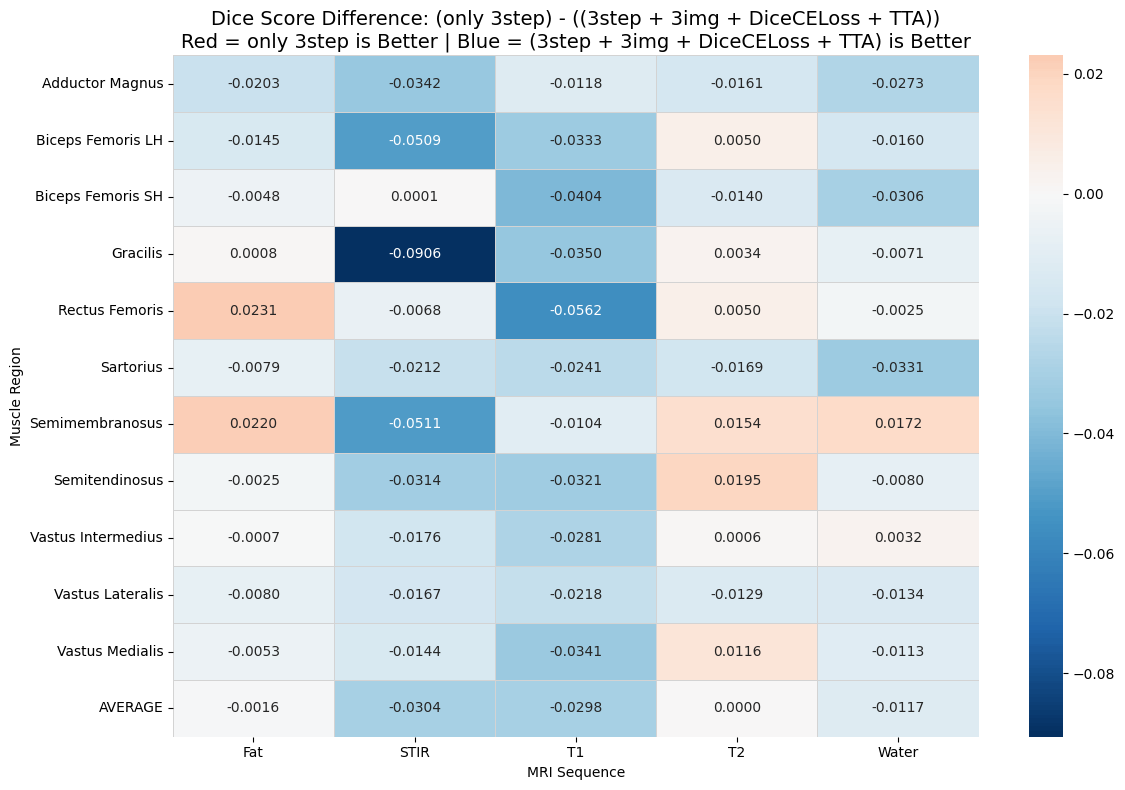

📊 分析報告: only 3step vs (3step + 3img + DiceCELoss + TTA)
📈 總體平均提升 (Total Average Gain): -0.0147

各序列提升 (Per Sequence Gain):
Fat     -0.001626
STIR    -0.030445
T1      -0.029765
T2       0.000041
Water   -0.011716
Name: AVERAGE, dtype: float64
--------------------------------------------------
🏆 受惠最多的前 3 名肌肉 (Top 3 Gainers from only 3step):
Semimembranosus      -0.001378
Rectus Femoris       -0.007495
Vastus Intermedius   -0.008509
dtype: float64
--------------------------------------------------
📉 受損最多的前 3 名肌肉 (Top 3 Losers):
Biceps Femoris LH   -0.021940
Adductor Magnus     -0.021952
Gracilis            -0.025697
dtype: float64


In [4]:
file1 = "/home/n26141826/114-1_TAICA_cv_Final_Project/results/results_3step_512/evaluation_metrics_per_sequence.csv"
file2 = "/home/n26141826/114-1_TAICA_cv_Final_Project/results/results_3step_256_hybridLoss/evaluation_metrics_per_sequence.csv"
# file1 = "/home/n26141826/114-1_TAICA_cv_Final_Project/results_3step_3img_new/evaluation_metrics_per_sequence_v3.csv"
# file2 = "/home/n26141826/114-1_TAICA_cv_Final_Project/results_3step_3img_new/evaluation_metrics_per_sequence_v4.csv"

# --- 正式執行比較 ---
compare_experiments(
    path_A=file1,  # 放你的 Warmup 結果路徑
    path_B=file2,    # 放你的 No-Warmup 結果路徑
    name_A="only 3step", 
    name_B="(3step + 3img + DiceCELoss + TTA)"
)